In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

from sklearn import set_config

set_config(transform_output="pandas")

In [2]:
df_customer = pd.read_csv("data/olist_customers_dataset.csv")
df_geoloc = pd.read_csv("data/olist_geolocation_dataset.csv")
df_order_item = pd.read_csv("data/olist_order_items_dataset.csv")
df_order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")
df_order_review = pd.read_csv("data/olist_order_reviews_dataset.csv")
df_order_list = pd.read_csv("data/olist_orders_dataset.csv")
df_product_list = pd.read_csv("data/olist_products_dataset.csv")
df_seller_list = pd.read_csv("data/olist_sellers_dataset.csv")
df_product_category_name = pd.read_csv("data/product_category_name_translation.csv")


## RFM

In [69]:
# Convertir la colonne order_purchase_timestamp en datetime
df_order_list['order_purchase_timestamp'] = pd.to_datetime(df_order_list['order_purchase_timestamp'])

# Calculer la date la plus récente
latest_date = df_order_list['order_purchase_timestamp'].max()

# Calculer la récence, la fréquence et le montant pour chaque client
# regroupe les commandes par client.
rfm = df_order_list.groupby('customer_id').agg({
    #calcule la différence de temps entre la date la plus récente (latest_date) et la date d'achat la plus récente pour chaque client (x.max()).
    'order_purchase_timestamp': lambda x: (latest_date - x.max()).days,
    'order_id': 'nunique',
}).reset_index()

# Renommer les colonnes
rfm.rename(columns={'order_purchase_timestamp': 'recency',
                     'order_id': 'frequency'}, inplace=True)

# Calculer le montant pour chaque client
monetary = df_order_item.groupby('order_id').agg({'price': 'sum'}).reset_index()
#Je merge les colonnes 'customer_id' et 'order_id' du dataframe 'df_order_list' au dataframe 'rfm' fusionner les données de deux dataframes sur'customer_id'
rfm = pd.merge(rfm, df_order_list[['customer_id', 'order_id']], on='customer_id')
rfm = pd.merge(rfm, monetary, on='order_id')
#Je drop la colonne order_id car j'ai fusionné les rfm et monetary sur la colonne order_id est elle est plus nécessaire maintenant
rfm.drop(['order_id'], axis=1, inplace=True)
rfm = rfm.groupby('customer_id').agg({'recency': 'min',
                                      'frequency': 'min',
                                      'price': 'sum'}).reset_index()
rfm.rename(columns={'price': 'monetary_value'}, inplace=True)

# Afficher le résultat
print(rfm.head())

                        customer_id  recency  frequency  monetary_value
0  00012a2ce6f8dcda20d059ce98491703      337          1           89.80
1  000161a058600d5901f007fab4c27140      458          1           54.90
2  0001fd6190edaaf884bcaf3d49edf079      596          1          179.99
3  0002414f95344307404f0ace7a26f1d5      427          1          149.90
4  000379cdec625522490c315e70c7a9fb      198          1           93.00


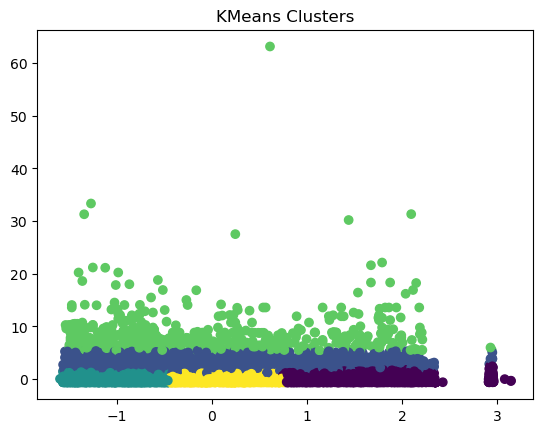

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardisation des données
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary_value']])

# Initialisation du modèle KMeans avec le nombre de clusters souhaité
kmeans = KMeans(n_clusters=5, random_state=1, n_init=10).fit(rfm_std)

# Visualisation des clusters
plt.scatter(rfm_std['recency'], rfm_std['monetary_value'], c=kmeans.labels_)
plt.title("KMeans Clusters")
plt.show()



In [72]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Standardisation des données
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary_value']])


# Je fais varier le nombre de clusters de 1 à 10
for n_clusters in range(1, 11):
    # Initialisation du modèle KMeans avec le nombre de clusters souhaité et entrainé le model avec la method fit
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(rfm_std)
   
   
    # Affichage de la somme des carrés des distances des échantillons au centre le plus proche
    print("Nombre de clusters : {} ; Inertie : {:.2f}".format(n_clusters, kmeans.inertia_))


Nombre de clusters : 1 ; Inertie : 197332.00
Nombre de clusters : 2 ; Inertie : 127909.82
Nombre de clusters : 3 ; Inertie : 76367.13
Nombre de clusters : 4 ; Inertie : 60561.79
Nombre de clusters : 5 ; Inertie : 45069.67
Nombre de clusters : 6 ; Inertie : 38911.09
Nombre de clusters : 7 ; Inertie : 35106.59
Nombre de clusters : 8 ; Inertie : 29453.87
Nombre de clusters : 9 ; Inertie : 26807.08
Nombre de clusters : 10 ; Inertie : 23837.64


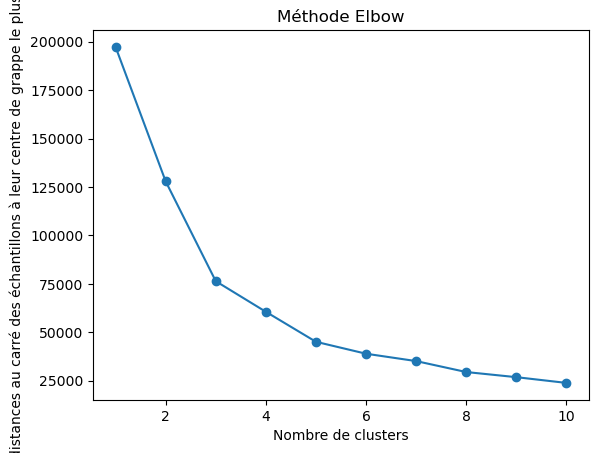

In [73]:
import matplotlib.pyplot as plt

# Initialisation de la liste pour stocker les valeurs d'inertie
inertias = []

for n_clusters in range(1, 11):
    # Initialisation du modèle KMeans avec le nombre de clusters souhaité
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(rfm_std)
    # Entraînement du modèle sur les données standardisées
    # Ajout de l'inertie à la liste
    inertias.append(kmeans.inertia_)

# Tracer la courbe d'inertie en fonction du nombre de clusters
plt.plot(range(1, 11), inertias, marker='o')
plt.title('Méthode Elbow')
plt.xlabel('Nombre de clusters')
# Description de la documentation
plt.ylabel("Somme des distances au carré des échantillons à leur centre de grappe le plus proche(Inertie)")
plt.show()



C:\Users\Sylvain\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


Variable : recency, F-value : nan, p-value : nan
Variable : frequency, F-value : nan, p-value : nan
Variable : monetary_value, F-value : nan, p-value : nan


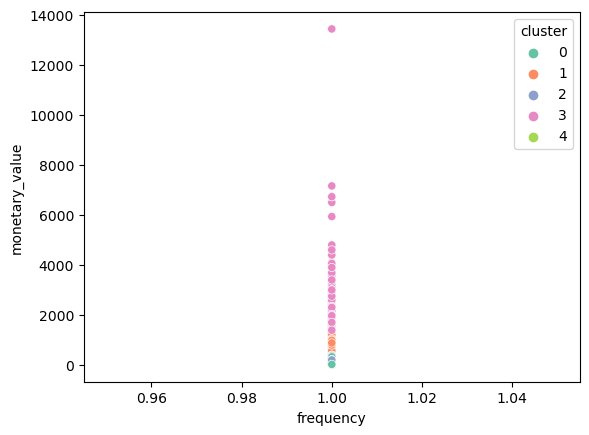

In [7]:
# Ajouter la colonne des clusters dans le dataframe
rfm['cluster'] = kmeans.labels_

# Afficher la moyenne des valeurs RFM pour chaque cluster
rfm.groupby('cluster').agg({'recency': 'mean', 'frequency': 'mean', 'monetary_value': 'mean'})

# Afficher le nombre de clients dans chaque cluster
rfm['cluster'].value_counts()

# Tracer un scatter plot pour visualiser les clusters
import seaborn as sns
sns.scatterplot(data=rfm, x='frequency', y='monetary_value', hue='cluster', palette='Set2')

# Faire une analyse de variance (ANOVA) pour voir s'il y a des différences significatives entre les clusters
from scipy.stats import f_oneway
for col in ['recency', 'frequency', 'monetary_value']:
    clusters = [rfm.loc[rfm['cluster'] == c, col] for c in range(n_clusters)]
    F, p = f_oneway(*clusters)
    print("Variable : {}, F-value : {:.2f}, p-value : {:.2f}".format(col, F, p))


In [70]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Réduction de dimension avec ACP
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_std)

# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=1)
rfm_tsne = tsne.fit_transform(rfm_std)
rfm_pca = rfm_pca.to_numpy()

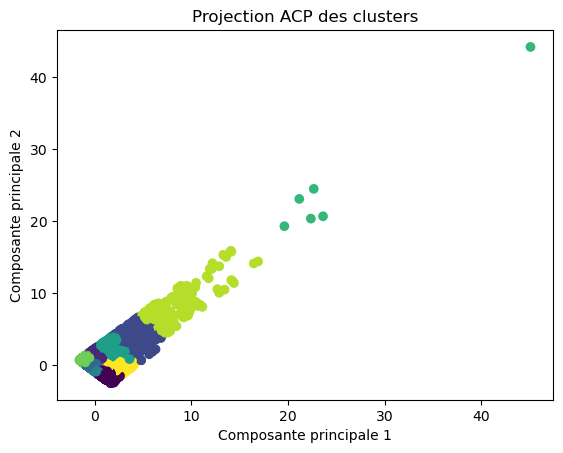

In [74]:

# Création d'un scatter plot pour les clusters obtenus avec KMeans
plt.scatter(rfm_pca[:,0], rfm_pca[:,1], c=kmeans.labels_)
plt.title('Projection ACP des clusters')
plt.xlabel('Composante principale 1')
plt.ylabel('Composante principale 2')
plt.show()


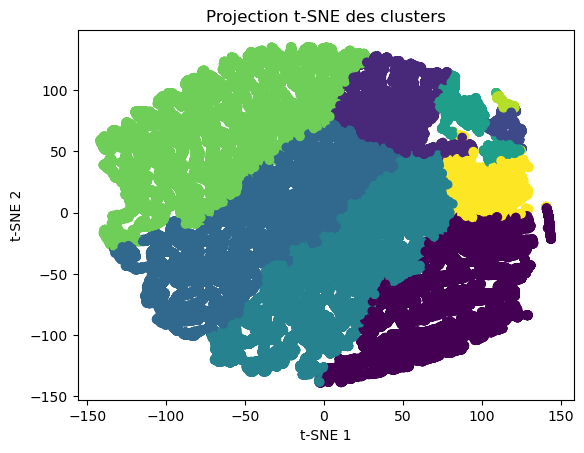

In [75]:

plt.scatter(rfm_tsne[:,0], rfm_tsne[:,1], c=kmeans.labels_)
plt.title('Projection t-SNE des clusters')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()


In [20]:
# Ajouter une colonne pour les labels de cluster
rfm['cluster'] = kmeans.labels_

# Définir les définitions pour chaque cluster
cluster_definitions = {
    0: "Clients peu récents avec des achats de faible valeur",
    1: "Clients récents et dépensiers",
    2: "Clients récents avec des achats de faible valeur",
    3: "Clients anciens mais très dépensiers",
    4: "Clients anciens avec des achats de faible valeur"
}

# Parcourir chaque cluster et afficher sa définition
for cluster_label, definition in cluster_definitions.items():
    print(f"Cluster {cluster_label}: {definition}")
    print("Recency mean:", round(rfm[rfm['cluster'] == cluster_label]['recency'].mean(), 2))
    print("Frequency mean:", round(rfm[rfm['cluster'] == cluster_label]['frequency'].mean(), 2))
    print("Monetary value mean:", round(rfm[rfm['cluster'] == cluster_label]['monetary_value'].mean(), 2))
    print()


Cluster 0: Clients peu récents avec des achats de faible valeur
Recency mean: 535.7
Frequency mean: 1.0
Monetary value mean: 81.33

Cluster 1: Clients récents et dépensiers
Recency mean: 195.32
Frequency mean: 1.0
Monetary value mean: 294.58

Cluster 2: Clients récents avec des achats de faible valeur
Recency mean: 310.19
Frequency mean: 1.0
Monetary value mean: 1301.79

Cluster 3: Clients anciens mais très dépensiers
Recency mean: 234.3
Frequency mean: 1.0
Monetary value mean: 78.49

Cluster 4: Clients anciens avec des achats de faible valeur
Recency mean: 364.09
Frequency mean: 1.0
Monetary value mean: 87.03



## Création dataframe Final

In [3]:
# Fusionner les données pour obtenir les noms de catégorie de produit par client
df_merged = pd.merge(df_customer, df_order_list, on='customer_id')
df_merged = pd.merge(df_merged, df_order_payments[['order_id', 'payment_type', 'payment_value']], on='order_id')
df_merged = pd.merge(df_merged, df_order_review[['order_id', 'review_score']], on='order_id')
df_merged = pd.merge(df_merged, df_order_item[['order_id', 'product_id']], on='order_id')
# Fusion des dataframes pour obtenir les informations nécessaires

# Fusion les données pour récuperer les categories de produits
df_orders = pd.merge(df_order_list, df_order_item, on="order_id")
df_orders = pd.merge(df_orders, df_product_list[["product_id", "product_category_name"]], on="product_id")
df_orders = pd.merge(df_orders, df_customer[["customer_id", "customer_unique_id"]], on="customer_id")


# Calculer la durée moyenne de livraison pour chaque client
df_merged['order_delivered_customer_date'] = pd.to_datetime(df_merged['order_delivered_customer_date'])
df_merged['order_purchase_timestamp'] = pd.to_datetime(df_merged['order_purchase_timestamp'])
df_merged['delivery_time'] = (df_merged['order_delivered_customer_date'] - df_merged['order_purchase_timestamp']).dt.days
mean_delivery_time = df_merged.groupby('customer_id')['delivery_time'].mean()

# Calculer le score moyen pour chaque client
mean_review_score = df_merged.groupby('customer_id')['review_score'].mean()

# Trouver le type de paiement le plus courant pour chaque client
most_common_payment_type = df_merged.groupby('customer_id')['payment_type'].agg(lambda x: x.value_counts().index[0])

# Trouver la ville pour chaque client
city = df_merged.groupby('customer_id')['customer_city'].agg(lambda x: x.value_counts().index[0])

# Calculer le prix moyen par commande pour chaque client
mean_order_price = df_merged.groupby('order_id')['payment_value'].mean()
mean_order_price = df_merged.groupby('customer_id')['order_id'].apply(lambda x: mean_order_price[x].mean())

# Calculer le nombre de commandes moyen par client
mean_order_count = df_merged.groupby('customer_id')['order_id'].nunique()

# Calculer le nombre de produits différents achetés par chaque client
num_products = df_merged.groupby('customer_id')['product_id'].nunique()

# Calculer la date de la dernière commande pour chaque client
last_order_date = df_merged.groupby('customer_id')['order_purchase_timestamp'].max()

# Calculer le nombre de produits différents achetés par chaque client
num_products = df_merged.groupby('customer_id')['product_id'].nunique()
#Recuperation des nom des category de produits 
df_product_categories = df_orders[["customer_id", "product_category_name"]]

#Fusionner les résultats dans un dataframe unique
df_final = pd.merge(mean_delivery_time, mean_review_score, on='customer_id')
df_final = pd.merge(df_final, most_common_payment_type, on='customer_id')
df_final = pd.merge(df_final, city, on='customer_id')
df_final = pd.merge(df_final, mean_order_price, on='customer_id')
df_final = pd.merge(df_final, num_products, on='customer_id')
df_final = pd.merge(df_final, mean_order_count, on='customer_id')
df_final = pd.merge(df_final, last_order_date, on='customer_id')


df_final = pd.merge(df_final, df_product_categories, on='customer_id')
#Renommer les colonnes du dataframe final
df_final.columns = ['customer_id','mean_delivery_time','mean_review_score', 'most_common_payment_type', 'city', 'mean_order_price','mean_order_count','num_products','last_order_date','df_product_categories']


In [5]:
df_final_copy = df_final.copy()

In [6]:
df_final_copy

,customer_id,mean_delivery_time,mean_review_score,most_common_payment_type,city,mean_order_price,mean_order_count,num_products,last_order_date,df_product_categories
0,00012a2ce6f8dcda20d059ce98491703,13.0,1.0,credit_card,osasco,114.74,1,1,2017-11-14 16:08:26,brinquedos
1,000161a058600d5901f007fab4c27140,9.0,4.0,credit_card,itapecerica,67.41,1,1,2017-07-16 09:40:32,beleza_saude
2,0001fd6190edaaf884bcaf3d49edf079,5.0,5.0,credit_card,nova venecia,195.42,1,1,2017-02-28 11:06:43,bebes
3,0002414f95344307404f0ace7a26f1d5,28.0,5.0,boleto,mendonca,179.35,1,1,2017-08-16 13:09:20,cool_stuff
4,000379cdec625522490c315e70c7a9fb,11.0,4.0,boleto,sao paulo,107.01,1,1,2018-04-02 13:42:17,cama_mesa_banho
...,...,...,...,...,...,...,...,...,...,...
111700,fffecc9f79fd8c764f843e9951b11341,12.0,3.0,voucher,parobe,27.12,1,1,2018-03-29 16:59:26,cama_mesa_banho
111701,fffeda5b6d849fbd39689bb92087f431,17.0,4.0,credit_card,rio de janeiro,63.13,1,1,2018-05-22 13:36:02,telefonia
111702,ffff42319e9b2d713724ae527742af25,5.0,5.0,credit_card,taboao da serra,214.13,1,1,2018-06-13 16:57:05,cama_mesa_banho
111703,ffffa3172527f765de70084a7e53aae8,12.0,5.0,credit_card,alfenas,45.50,1,1,2017-09-02 11:53:32,moveis_decoracao


### Debut dataframe sans variables categorielles

In [8]:
#Suppression des variables categorielles
df_encode_final = df_final_copy.drop(['customer_id','most_common_payment_type','city','last_order_date','df_product_categories'],axis=1)

In [93]:
from sklearn.preprocessing import OneHotEncoder

# Instancier l'objet OneHotEncoder avec min_frequency
encoder = OneHotEncoder(handle_unknown='error', sparse_output=False, min_frequency = 0.05)

# Encoder les colonnes 'product_category_name', 'most_common_payment_type', et 'city'
columns_to_encode = ['most_common_payment_type', 'city','df_product_categories']
encoded_features = encoder.fit_transform(df_final_copy[columns_to_encode])

# Générer les noms de colonnes pour le DataFrame d'encodage
encoded_columns = encoder.get_feature_names_out(columns_to_encode)

# Créer un DataFrame à partir des résultats de l'encodage
df_encoded = pd.DataFrame(encoded_features, columns=encoded_columns)

# Concaténer le DataFrame d'encodage avec le DataFrame original
df_encoding = pd.concat([df_final_copy, df_encoded], axis=1)

# Supprimer les colonnes originales encodées
df_encoding.drop(columns_to_encode, axis=1, inplace=True)

In [94]:
df_encode = df_encoding.copy()

In [95]:
df_encode

,customer_id,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products,last_order_date,most_common_payment_type_boleto,most_common_payment_type_credit_card,most_common_payment_type_infrequent_sklearn,...,city_sao paulo,city_infrequent_sklearn,df_product_categories_beleza_saude,df_product_categories_cama_mesa_banho,df_product_categories_esporte_lazer,df_product_categories_informatica_acessorios,df_product_categories_moveis_decoracao,df_product_categories_relogios_presentes,df_product_categories_utilidades_domesticas,df_product_categories_infrequent_sklearn
0,00012a2ce6f8dcda20d059ce98491703,13.0,1.0,114.74,1,1,2017-11-14 16:08:26,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,000161a058600d5901f007fab4c27140,9.0,4.0,67.41,1,1,2017-07-16 09:40:32,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0001fd6190edaaf884bcaf3d49edf079,5.0,5.0,195.42,1,1,2017-02-28 11:06:43,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0002414f95344307404f0ace7a26f1d5,28.0,5.0,179.35,1,1,2017-08-16 13:09:20,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,000379cdec625522490c315e70c7a9fb,11.0,4.0,107.01,1,1,2018-04-02 13:42:17,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111700,fffecc9f79fd8c764f843e9951b11341,12.0,3.0,27.12,1,1,2018-03-29 16:59:26,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111701,fffeda5b6d849fbd39689bb92087f431,17.0,4.0,63.13,1,1,2018-05-22 13:36:02,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111702,ffff42319e9b2d713724ae527742af25,5.0,5.0,214.13,1,1,2018-06-13 16:57:05,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111703,ffffa3172527f765de70084a7e53aae8,12.0,5.0,45.50,1,1,2017-09-02 11:53:32,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


C:\Users\Sylvain\AppData\Local\Temp\ipykernel_13996\3196257526.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_encode.corr(), cmap='coolwarm', annot=True)


<Axes: >

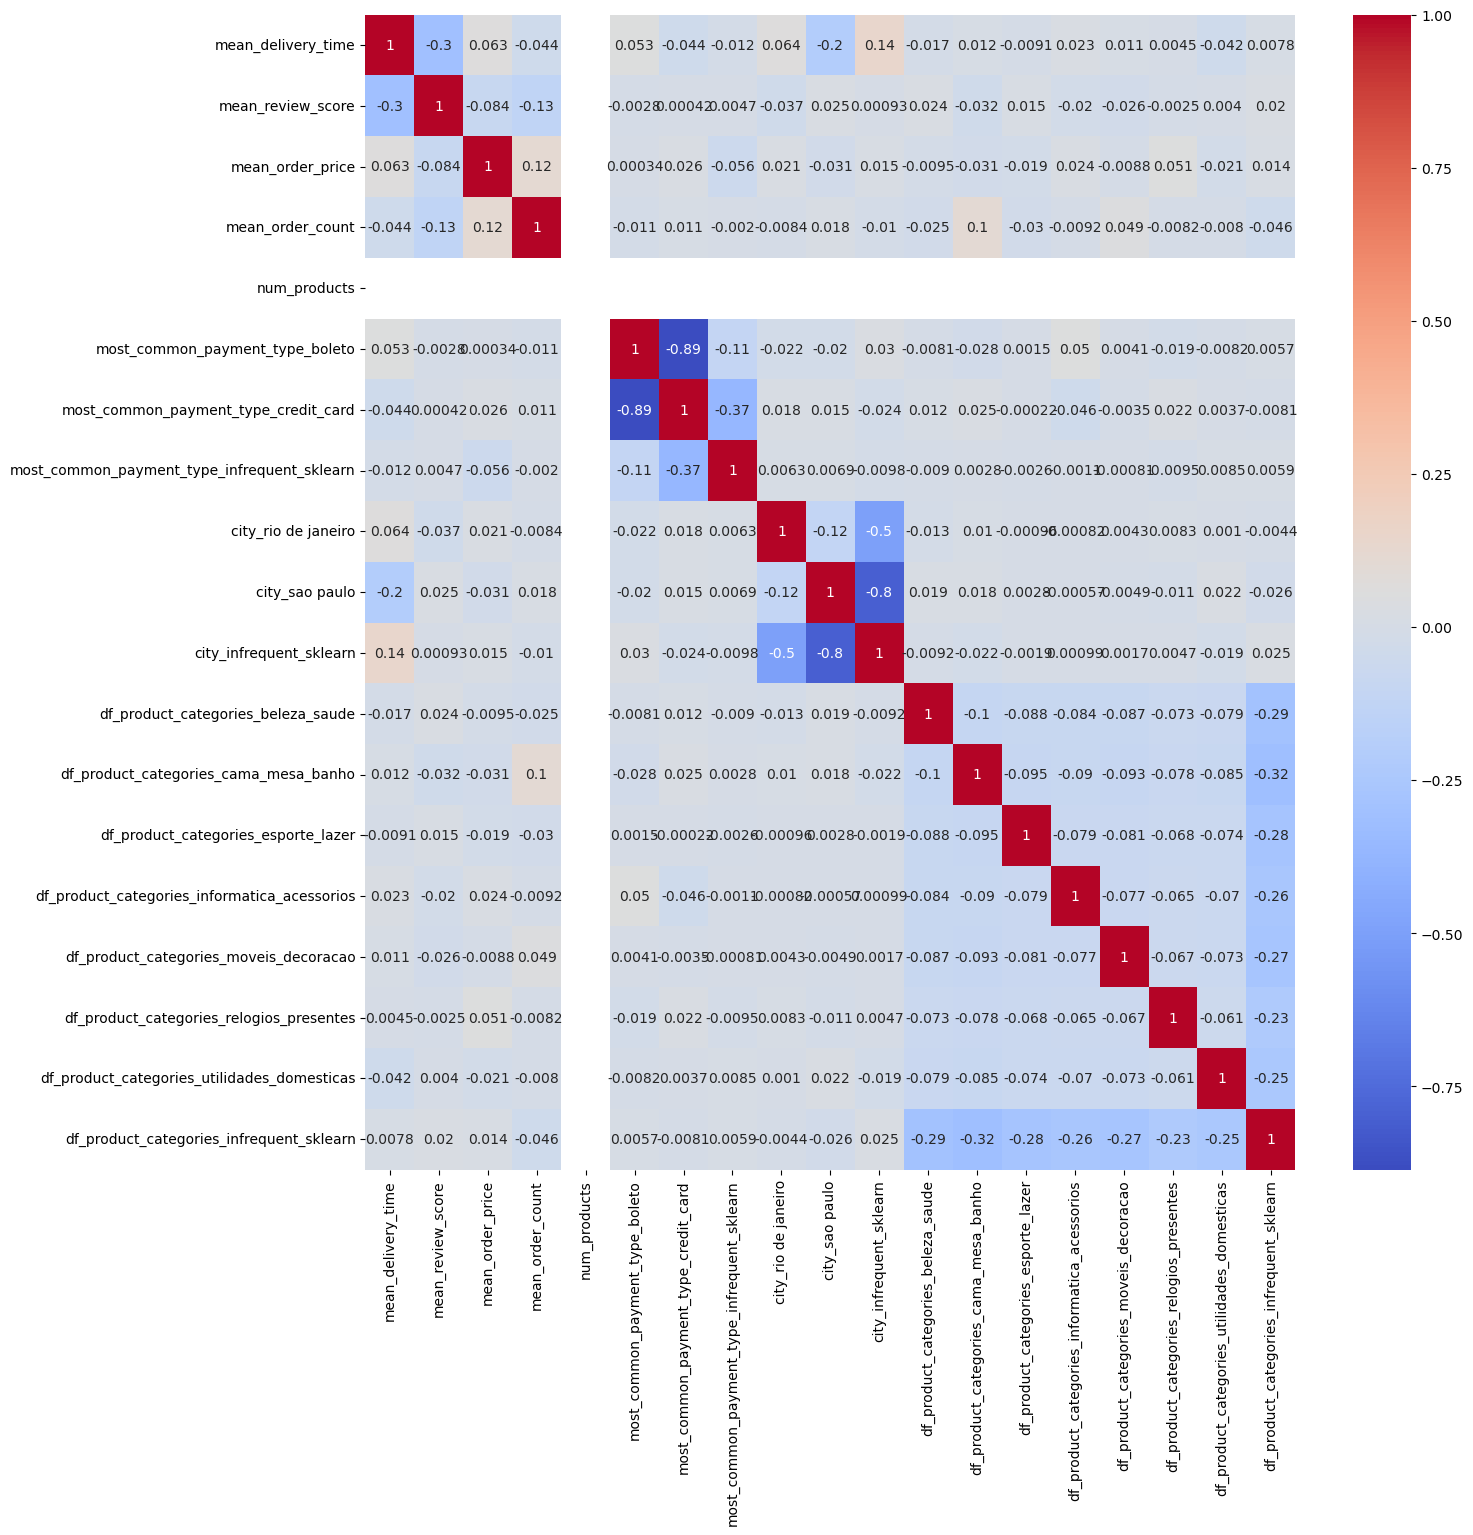

In [27]:
import seaborn as sns

# Créer une heatmap des corrélations
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_encode.corr(), cmap='coolwarm', annot=True)

In [96]:
#Suppression des colonnes inutile 
df_encode = df_encode.drop(['city_infrequent_sklearn','customer_id','last_order_date'],axis=1)

In [97]:
df_encode

,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products,most_common_payment_type_boleto,most_common_payment_type_credit_card,most_common_payment_type_infrequent_sklearn,city_rio de janeiro,city_sao paulo,df_product_categories_beleza_saude,df_product_categories_cama_mesa_banho,df_product_categories_esporte_lazer,df_product_categories_informatica_acessorios,df_product_categories_moveis_decoracao,df_product_categories_relogios_presentes,df_product_categories_utilidades_domesticas,df_product_categories_infrequent_sklearn
0,13.0,1.0,114.74,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9.0,4.0,67.41,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,5.0,195.42,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,28.0,5.0,179.35,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,11.0,4.0,107.01,1,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111700,12.0,3.0,27.12,1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111701,17.0,4.0,63.13,1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111702,5.0,5.0,214.13,1,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111703,12.0,5.0,45.50,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<Axes: >

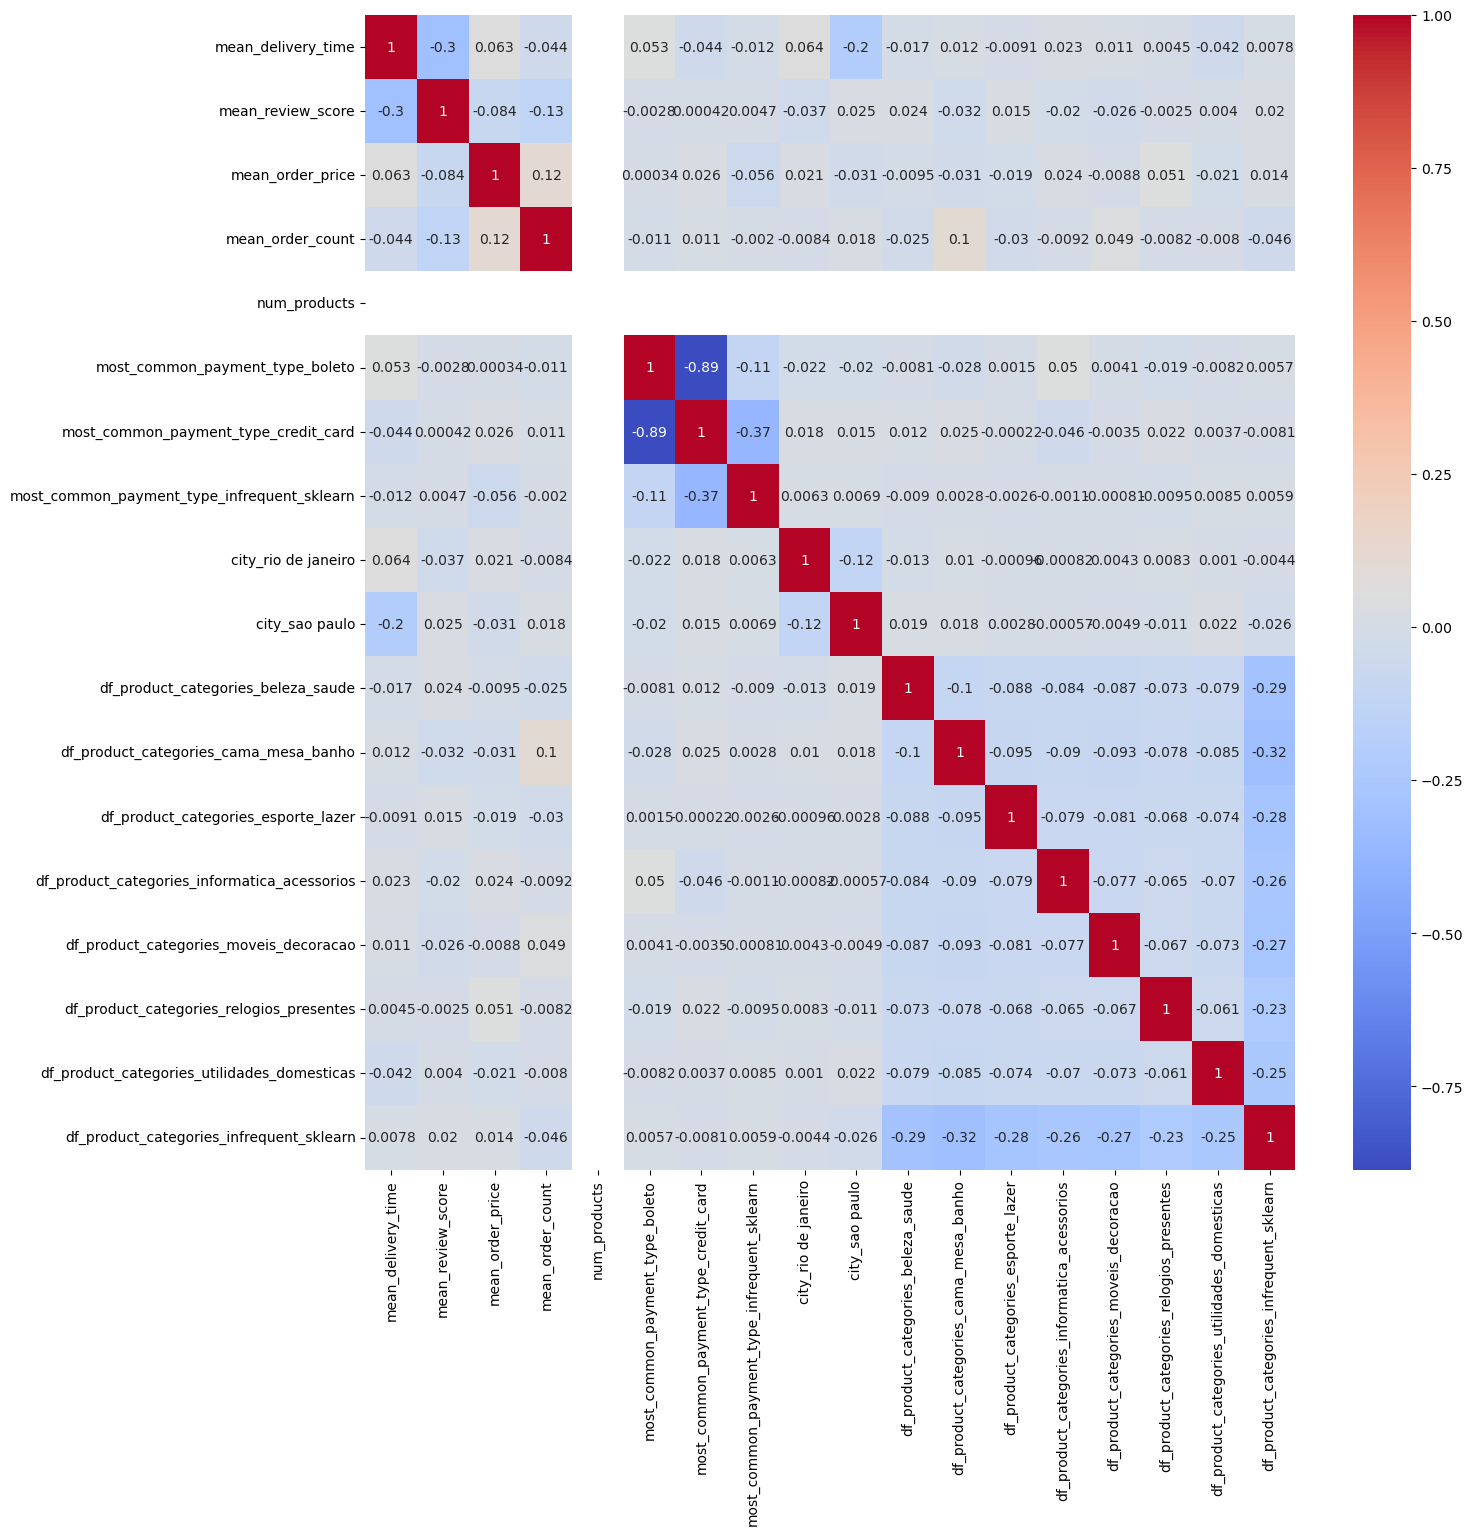

In [30]:
import seaborn as sns

# Créer une heatmap des corrélations
fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_encode.corr(), cmap='coolwarm', annot=True)

In [98]:
df_encode_final = df_encode.copy()

In [99]:
df_encode_final

,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products,most_common_payment_type_boleto,most_common_payment_type_credit_card,most_common_payment_type_infrequent_sklearn,city_rio de janeiro,city_sao paulo,df_product_categories_beleza_saude,df_product_categories_cama_mesa_banho,df_product_categories_esporte_lazer,df_product_categories_informatica_acessorios,df_product_categories_moveis_decoracao,df_product_categories_relogios_presentes,df_product_categories_utilidades_domesticas,df_product_categories_infrequent_sklearn
0,13.0,1.0,114.74,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9.0,4.0,67.41,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.0,5.0,195.42,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,28.0,5.0,179.35,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,11.0,4.0,107.01,1,1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111700,12.0,3.0,27.12,1,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111701,17.0,4.0,63.13,1,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
111702,5.0,5.0,214.13,1,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
111703,12.0,5.0,45.50,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(transform_output="pandas")
scaler = StandardScaler()
df_encode_final = scaler.fit_transform(df_encode_final)

In [10]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
df_model_imputed = imputer.fit_transform(df_encode_final['mean_delivery_time'].values.reshape(-1, 1))
df_encode_final['mean_delivery_time'] = df_model_imputed

In [11]:
#Après suppression des valeurs categorielles
df_encode_final

,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products
0,0.110587,-2.188397,-0.231406,-0.234952,0.0
1,-0.316506,-0.023960,-0.407433,-0.234952,0.0
2,-0.743599,0.697519,0.068653,-0.234952,0.0
3,1.712184,0.697519,0.008887,-0.234952,0.0
4,-0.102960,-0.023960,-0.260155,-0.234952,0.0
...,...,...,...,...,...
111700,0.003813,-0.745439,-0.557277,-0.234952,0.0
111701,0.537679,-0.023960,-0.423351,-0.234952,0.0
111702,-0.743599,0.697519,0.138238,-0.234952,0.0
111703,0.003813,0.697519,-0.488919,-0.234952,0.0


In [102]:
df_encode_final

,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products,most_common_payment_type_boleto,most_common_payment_type_credit_card,most_common_payment_type_infrequent_sklearn,city_rio de janeiro,city_sao paulo,df_product_categories_beleza_saude,df_product_categories_cama_mesa_banho,df_product_categories_esporte_lazer,df_product_categories_informatica_acessorios,df_product_categories_moveis_decoracao,df_product_categories_relogios_presentes,df_product_categories_utilidades_domesticas,df_product_categories_infrequent_sklearn
0,0.110587,-2.188397,-0.231406,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
1,-0.316506,-0.023960,-0.407433,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,3.264069,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
2,-0.743599,0.697519,0.068653,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
3,1.712184,0.697519,0.008887,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
4,-0.102960,-0.023960,-0.260155,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,2.306965,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111700,0.003813,-0.745439,-0.557277,-0.234952,0.0,-0.504793,-1.755574,4.781578,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
111701,0.537679,-0.023960,-0.423351,-0.234952,0.0,-0.504793,0.569614,-0.209136,3.666010,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
111702,-0.743599,0.697519,0.138238,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
111703,0.003813,0.697519,-0.488919,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,3.541186,-0.236986,-0.256943,-0.961607


<Axes: >

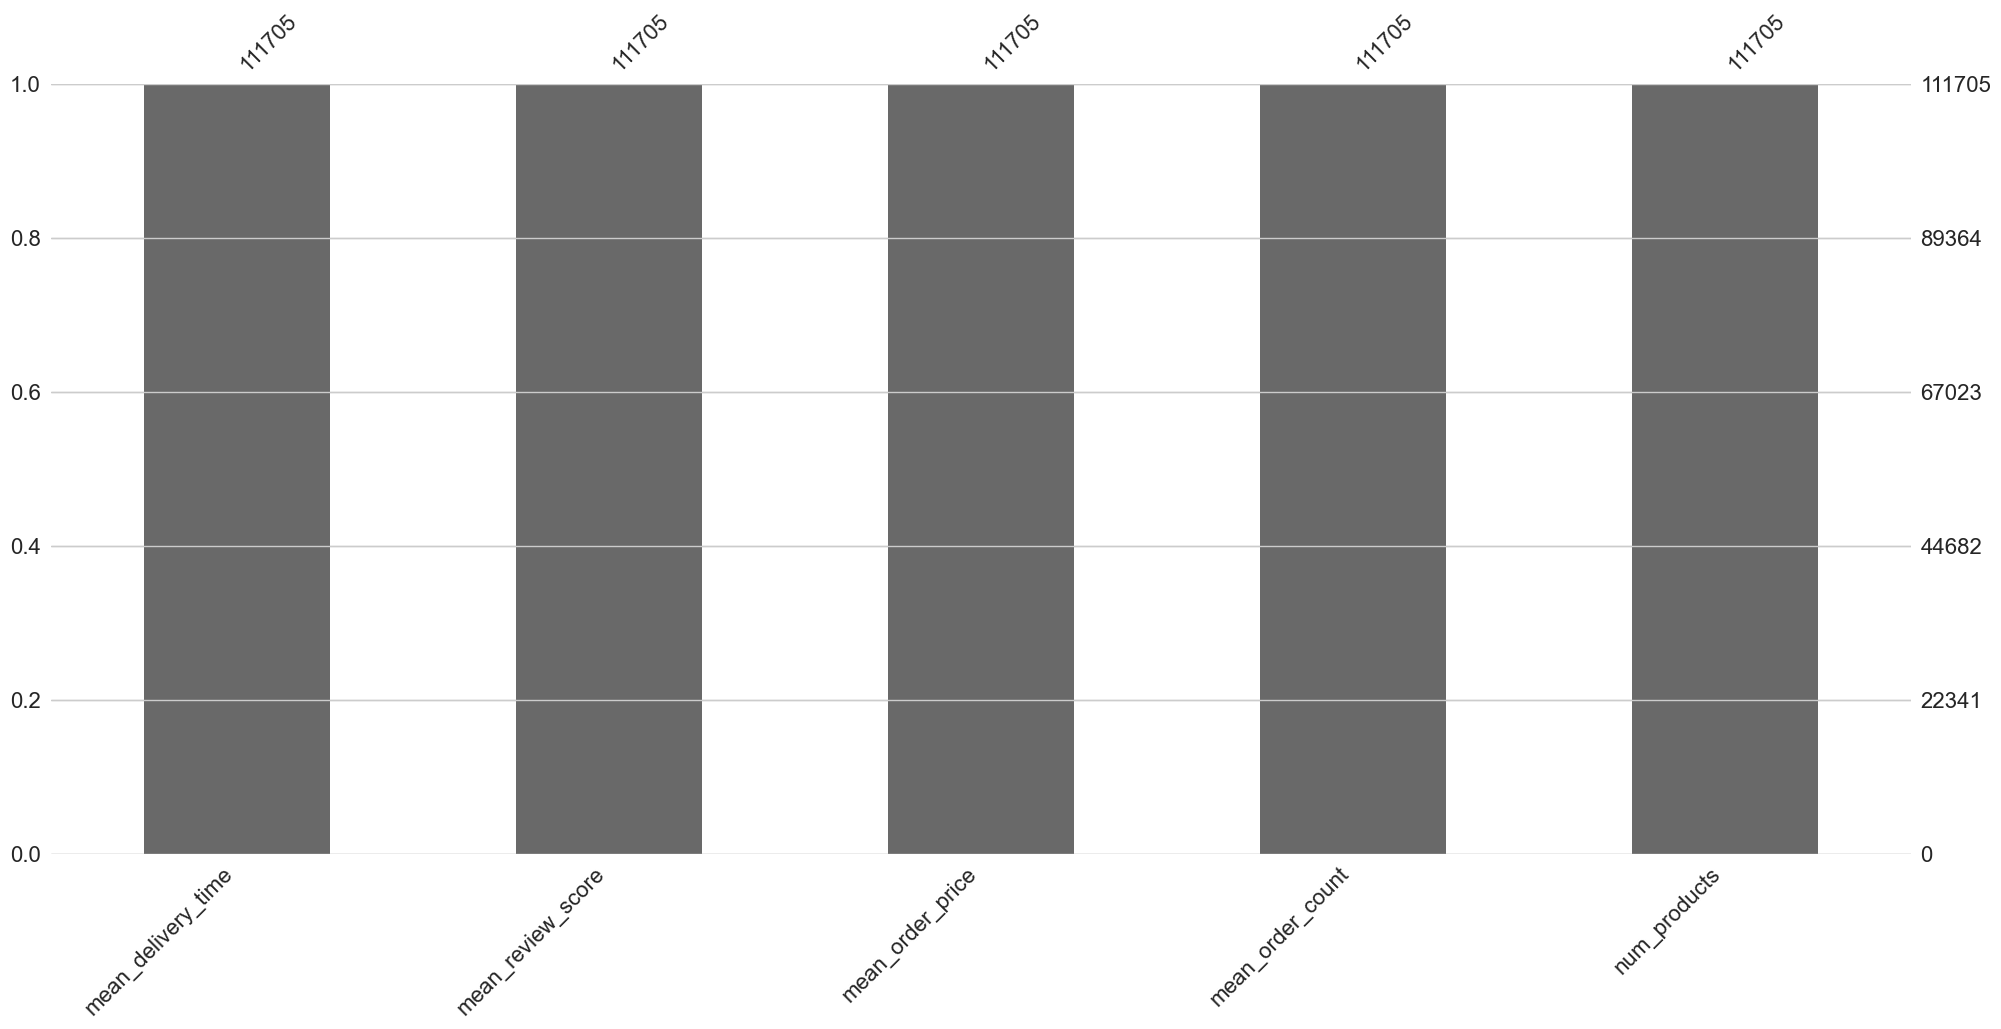

In [20]:
msno.bar(df_encode_final)

<Axes: >

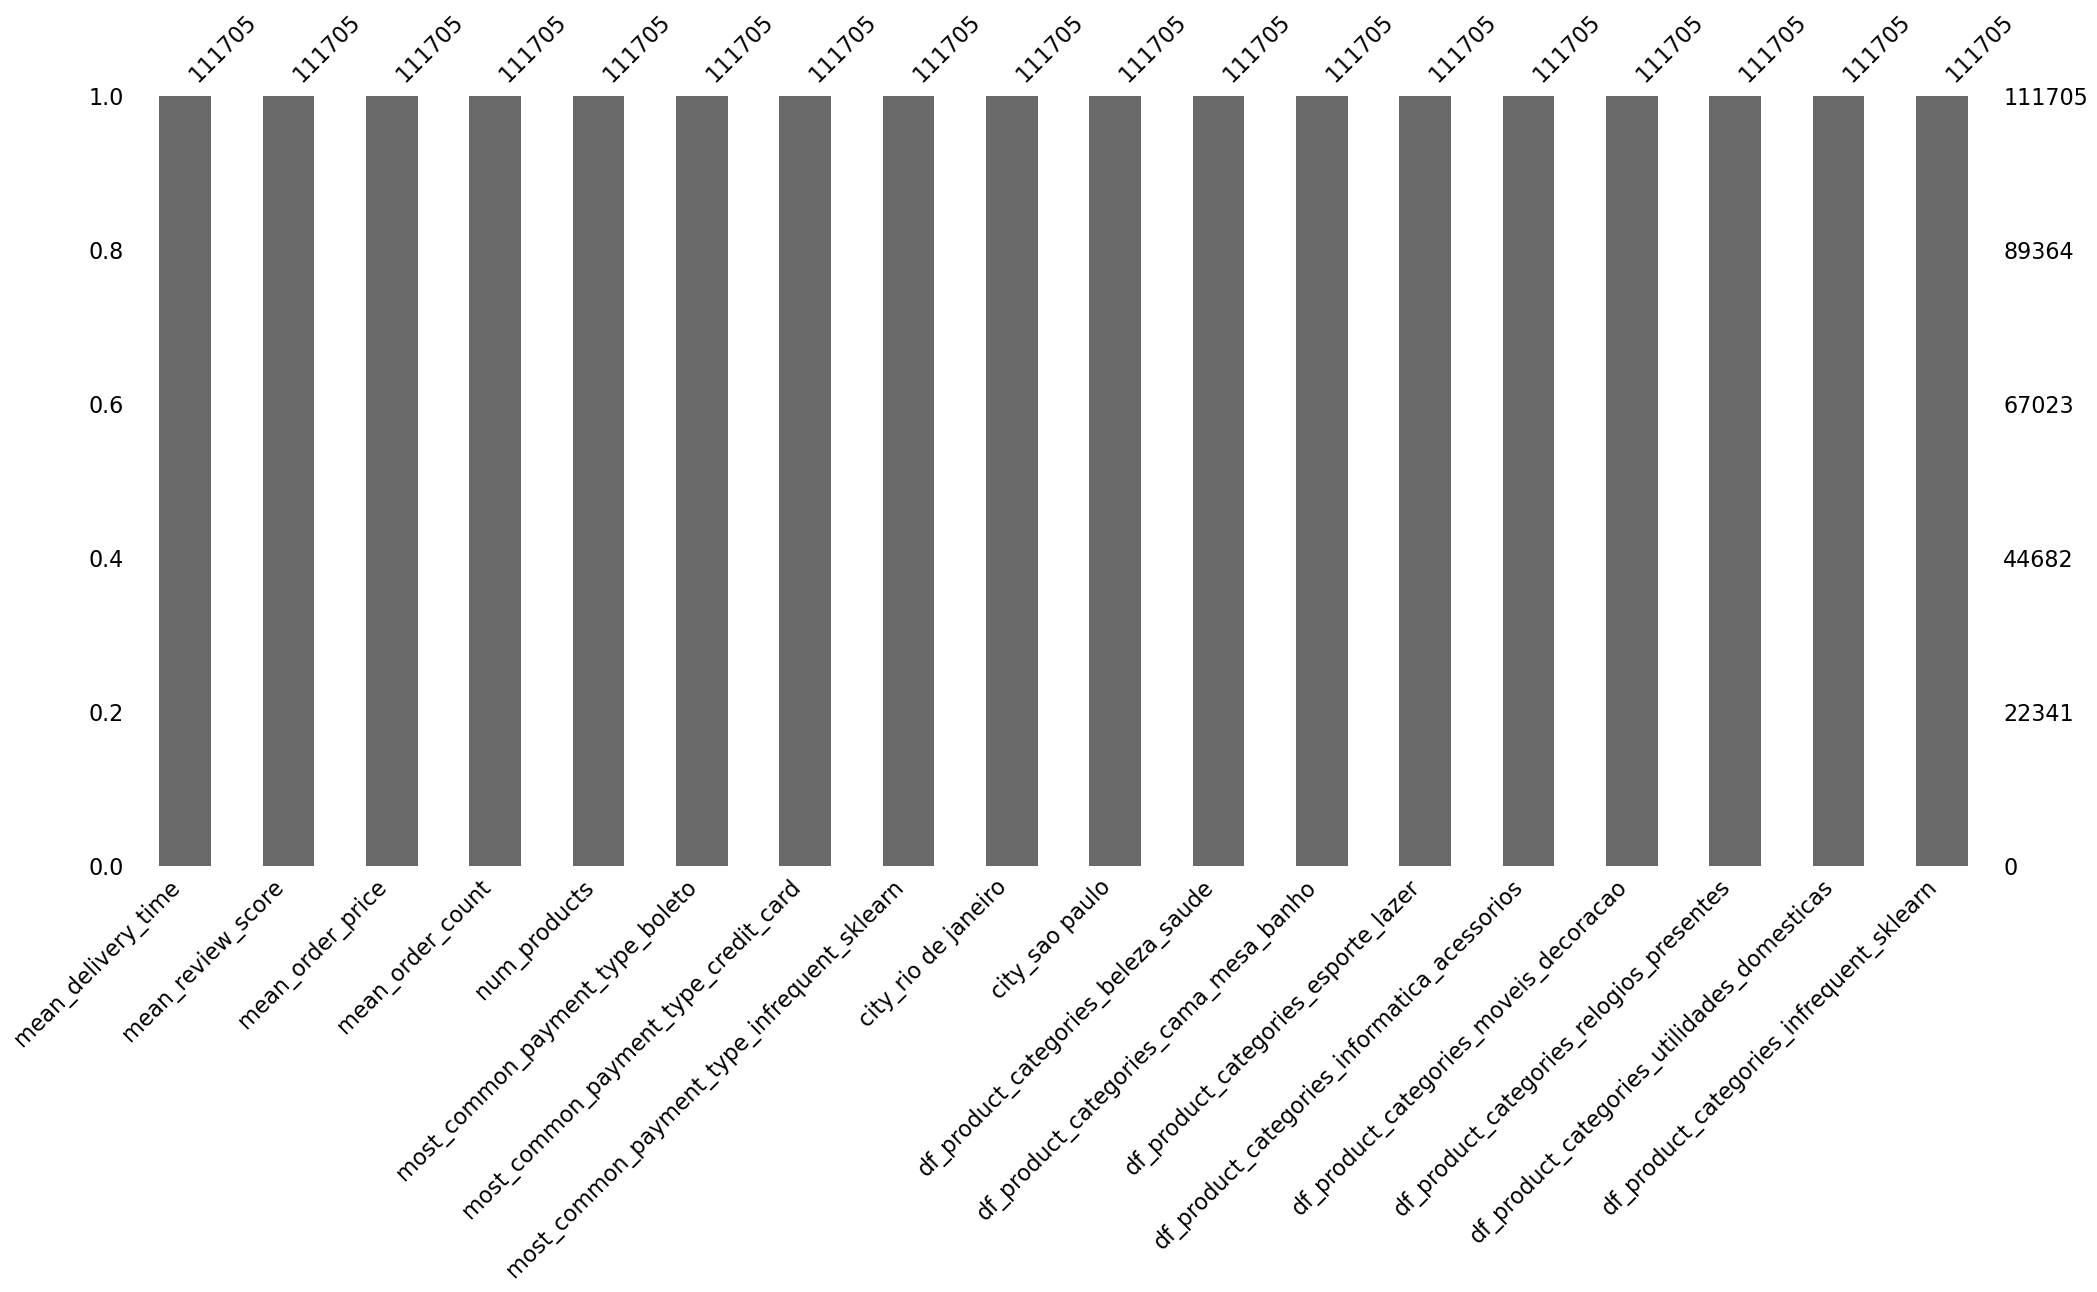

In [103]:
msno.bar(df_encode_final)

In [37]:
df_encode_final

,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products,most_common_payment_type_boleto,most_common_payment_type_credit_card,most_common_payment_type_infrequent_sklearn,city_rio de janeiro,city_sao paulo,df_product_categories_beleza_saude,df_product_categories_cama_mesa_banho,df_product_categories_esporte_lazer,df_product_categories_informatica_acessorios,df_product_categories_moveis_decoracao,df_product_categories_relogios_presentes,df_product_categories_utilidades_domesticas,df_product_categories_infrequent_sklearn
0,0.110587,-2.188397,-0.231406,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
1,-0.316506,-0.023960,-0.407433,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,3.264069,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
2,-0.743599,0.697519,0.068653,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
3,1.712184,0.697519,0.008887,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
4,-0.102960,-0.023960,-0.260155,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,2.306965,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111700,0.003813,-0.745439,-0.557277,-0.234952,0.0,-0.504793,-1.755574,4.781578,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
111701,0.537679,-0.023960,-0.423351,-0.234952,0.0,-0.504793,0.569614,-0.209136,3.666010,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
111702,-0.743599,0.697519,0.138238,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
111703,0.003813,0.697519,-0.488919,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,3.541186,-0.236986,-0.256943,-0.961607


## KMEANS

In [12]:
from sklearn.cluster import KMeans

for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(df_encode_final)

    print("Nombre de clusters : {} ; Inertie : {:.2f}".format(n_clusters, kmeans.inertia_))

Nombre de clusters : 1 ; Inertie : 444481.00
Nombre de clusters : 2 ; Inertie : 356813.71
Nombre de clusters : 3 ; Inertie : 263856.16
Nombre de clusters : 4 ; Inertie : 230529.46
Nombre de clusters : 5 ; Inertie : 183323.10
Nombre de clusters : 6 ; Inertie : 161260.66
Nombre de clusters : 7 ; Inertie : 151435.94
Nombre de clusters : 8 ; Inertie : 133776.36
Nombre de clusters : 9 ; Inertie : 116980.27
Nombre de clusters : 10 ; Inertie : 104554.39


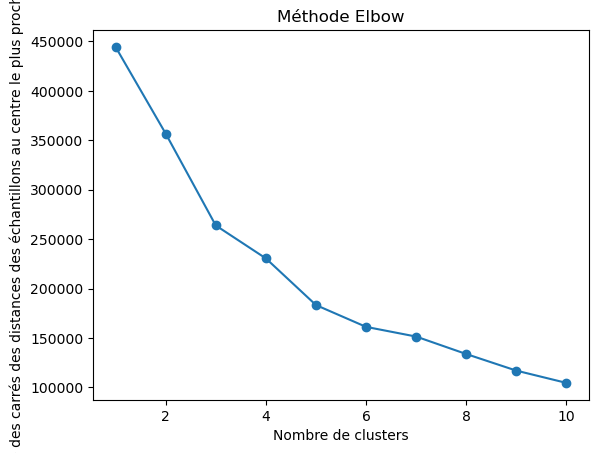

In [13]:
#Après suppression des variables categorielles
inertias = []

for n_clusters in range(1, 11):
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(df_encode_final)

    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Méthode Elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel("Somme des carrés des distances des échantillons au centre le plus proche (inertie)")
plt.show()

In [21]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(df_encode_final)
    labels = kmeans.labels_
    score = silhouette_score(df_encode_final, labels)
    print(f"Silhouette score for {n_clusters} clusters: {score}")

Silhouette score for 2 clusters: 0.5732005782697601
Silhouette score for 3 clusters: 0.5058885095628838
Silhouette score for 4 clusters: 0.4570426488721141
Silhouette score for 5 clusters: 0.4759970706127628
Silhouette score for 6 clusters: 0.38340711310714454
Silhouette score for 7 clusters: 0.3570344530211387
Silhouette score for 8 clusters: 0.39584126526921254
Silhouette score for 9 clusters: 0.39763019645055925
Silhouette score for 10 clusters: 0.4071050508190033


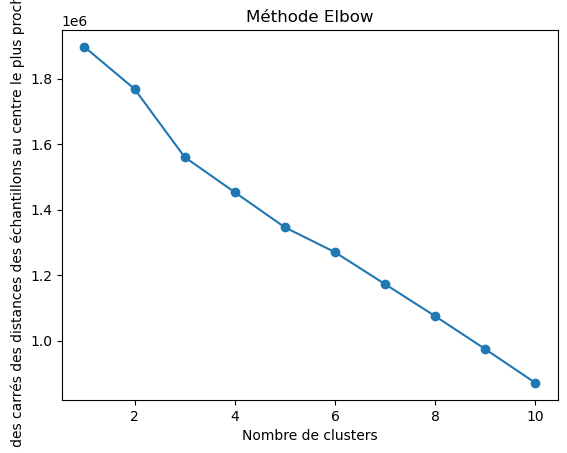

In [39]:

inertias = []

for n_clusters in range(1, 11):
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(df_encode_final)

    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.title('Méthode Elbow')
plt.xlabel('Nombre de clusters')
plt.ylabel("Somme des carrés des distances des échantillons au centre le plus proche (inertie)")
plt.show()

In [40]:
from sklearn.metrics import silhouette_score
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1, n_init='auto').fit(df_encode_final)
    labels = kmeans.labels_
    score = silhouette_score(df_encode_final, labels)
    print(f"Silhouette score for {n_clusters} clusters: {score}")


Silhouette score for 2 clusters: 0.3030162523552648
Silhouette score for 3 clusters: 0.2104524910376472
Silhouette score for 4 clusters: 0.2329086452924087
Silhouette score for 5 clusters: 0.24559866200540942
Silhouette score for 6 clusters: 0.22288980237644304
Silhouette score for 7 clusters: 0.2497345129025157
Silhouette score for 8 clusters: 0.27377672613567877
Silhouette score for 9 clusters: 0.29725265032524745
Silhouette score for 10 clusters: 0.3234853506349027


In [16]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [17]:

# Réduire la dimensionnalité des données en utilisant PCA
pca = PCA(n_components=2)
df_pca_final = pca.fit_transform(df_encode_final)

# Instancier le modèle KMeans avec le nombre de clusters souhaité
model = KMeans(n_clusters=5, random_state=1, n_init='auto').fit(df_pca_final)



C:\Users\Sylvain\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


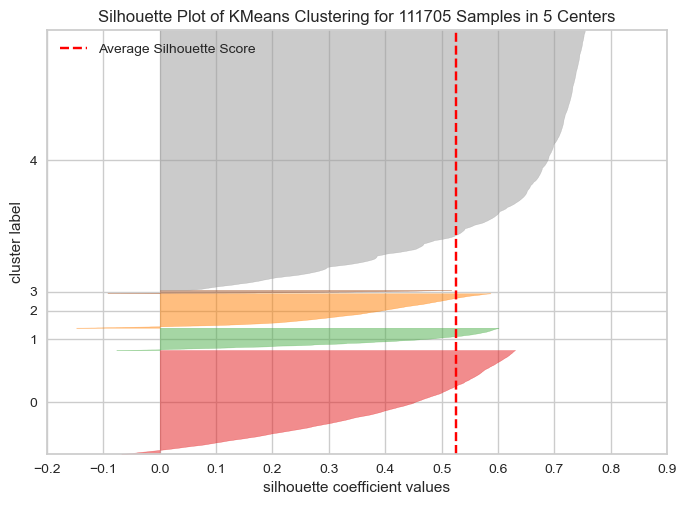

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 111705 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [19]:
# Instancier la classe SilhouetteVisualizer avec le modèle KMeans
visualizer = SilhouetteVisualizer(model)

# Adapter la classe SilhouetteVisualizer aux données réduites en dimensionnalité
visualizer.fit(df_pca_final)

# Afficher la visualisation des silhouettes des clusters
visualizer.poof()

## Fin dataframe sans one hot encoder

In [24]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Initialisation du modèle KMeans avec le nombre de clusters souhaité
kmeans = KMeans(n_clusters=7, random_state=1, n_init='auto').fit(df_encode_final)

In [25]:
# Réduction de dimension avec PCA à 2 composantes
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_encode_final)

# Projection 2D t-SNE
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=1)
tsne_result = tsne.fit_transform(df_encode_final)

In [26]:
pca_results = pca_result.copy()

In [27]:
# Convertir le dataframe en un tableau NumPy
pca_array = pca_result.to_numpy()

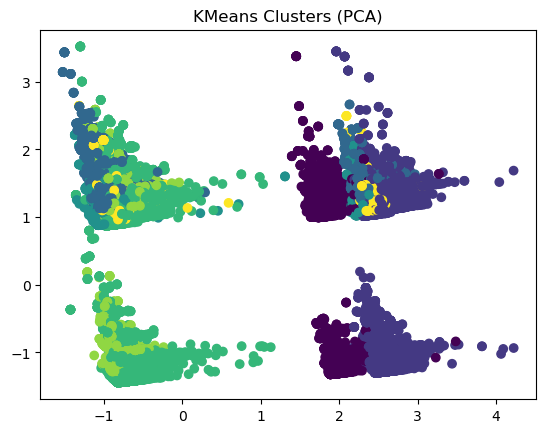

In [28]:
# Visualisation des clusters avec PCA
plt.scatter(pca_array[:, 0], pca_array[:, 1], c=kmeans.labels_)
plt.title("KMeans Clusters (PCA)")
plt.show()

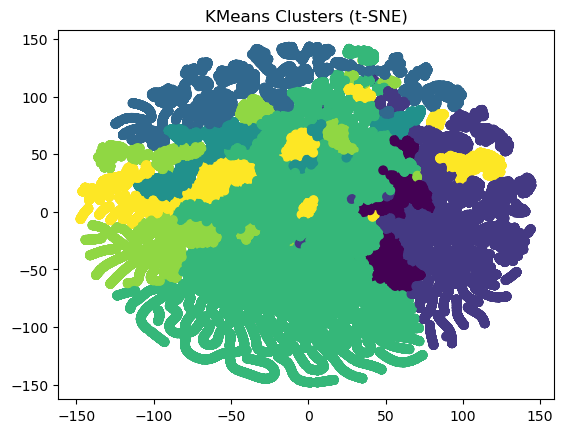

In [29]:
# Visualisation des clusters avec t-SNE
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans.labels_)
plt.title("KMeans Clusters (t-SNE)")
plt.show()

In [30]:
# Ajouter une colonne pour les labels de cluster
df_encode_final['cluster'] = kmeans.labels_

# Définir les définitions pour chaque cluster
cluster_definitions = {
    0: "Clients peu engagés : Paiement avec Boleto et achat de produits de beauté/santé et d'articles de literie/salle de bain",
    1: "Clients récents et fidèles : Paiement par carte de crédit et achat de produits d'informatique/accessoires et de meubles/décoration",
    2: "Clients anciens mais peu dépensiers : Paiement avec Boleto et achat de produits de sport/loisirs et d'articles pour la maison",
    3: "Clients très engagés : Paiement par carte de crédit et achat de produits de sport/loisirs et d'articles pour la maison",
    4: "Clients peu récents mais dépensiers : Paiement par carte de crédit et achat de produits de beauté/santé et d'articles pour la maison",
    5: "Clients récents mais peu engagés : Paiement avec Boleto et achat de produits de sport/loisirs et d'articles pour la maison",
    6: "Clients moyennement engagés : Paiement par carte de crédit et achat de produits de sport/loisirs et d'articles pour la maison",
}
# Liste de variables à comparer
variables_to_compare = ['mean_delivery_time', 'mean_review_score', 'mean_order_price', 'most_common_payment_type_boleto', 'most_common_payment_type_credit_card', 'df_product_categories_beleza_saude', 'df_product_categories_cama_mesa_banho', 'df_product_categories_esporte_lazer', 'df_product_categories_informatica_acessorios', 'df_product_categories_moveis_decoracao', 'df_product_categories_relogios_presentes', 'df_product_categories_utilidades_domesticas']

# Parcourir chaque cluster et afficher sa définition et les moyennes pour chaque variable
for cluster_label, definition in cluster_definitions.items():
    print(f"Cluster {cluster_label}: {definition}")
    for variable in variables_to_compare:
        if 'most_common_payment_type' in variable:
            payment_type = variable.split('_')[-1]
            print(f"Paiement le plus commun : {payment_type} mean:", round(df_encode_final[df_encode_final['cluster'] == cluster_label][variable].mean(), 2))
        elif 'df_product_categories' in variable:
            category = variable.split('_')[-1]
            print(f"Achat de produits {category} mean:", round(df_encode_final[df_encode_final['cluster'] == cluster_label][variable].mean(), 2))
        else:
            print(f"{variable} mean:", round(df_encode_final[df_encode_final['cluster'] == cluster_label][variable].mean(), 2))
    print()


Cluster 0: Clients peu engagés : Paiement avec Boleto et achat de produits de beauté/santé et d'articles de literie/salle de bain
mean_delivery_time mean: -0.06
mean_review_score mean: 0.02
mean_order_price mean: -0.28
Paiement le plus commun : boleto mean: -0.5
Paiement le plus commun : card mean: -1.76
Achat de produits saude mean: -0.04
Achat de produits banho mean: 0.01
Achat de produits lazer mean: -0.01
Achat de produits acessorios mean: -0.01
Achat de produits decoracao mean: -0.0
Achat de produits presentes mean: -0.05
Achat de produits domesticas mean: 0.04

Cluster 1: Clients récents et fidèles : Paiement par carte de crédit et achat de produits d'informatique/accessoires et de meubles/décoration
mean_delivery_time mean: 0.12
mean_review_score mean: -0.0
mean_order_price mean: 0.02
Paiement le plus commun : boleto mean: 1.98
Paiement le plus commun : card mean: -1.76
Achat de produits saude mean: -0.31
Achat de produits banho mean: -0.33
Achat de produits lazer mean: 0.08
Ach

In [46]:
# Entraîner le modèle KMeans
kmeans = KMeans(n_clusters=7, random_state=1, n_init='auto').fit(df_encode_final)

# Obtenir les étiquettes de cluster pour chaque échantillon
labels = kmeans.predict(df_encode_final)

# Ajouter les étiquettes de cluster à vos données
df_encode_final['cluster'] = labels

# Compter le nombre de clients dans chaque cluster
cluster_sizes = pd.Series(labels).value_counts()

# Afficher les tailles de cluster
print("Tailles de cluster:\n", cluster_sizes)
print("\nStatistiques descriptives:\n", cluster_sizes.describe())

Tailles de cluster:
 4    53563
1    17977
2    10503
5    10002
6     9240
3     5741
0     4679
dtype: int64

Statistiques descriptives:
 count        7.000000
mean     15957.857143
std      17127.841861
min       4679.000000
25%       7490.500000
50%      10002.000000
75%      14240.000000
max      53563.000000
dtype: float64


In [32]:
# Regrouper les clients par cluster et calculer les caractéristiques moyennes
cluster_means = df_encode_final.groupby('cluster').mean()

# Afficher les caractéristiques moyennes de chaque cluster
print("Caractéristiques moyennes de chaque cluster:\n", cluster_means)

Caractéristiques moyennes de chaque cluster:
          mean_delivery_time  mean_review_score  mean_order_price  \
cluster                                                            
0                 -0.055895           0.022561         -0.269101   
1                  0.137460          -0.021422          0.043573   
2                 -0.048823           0.078705         -0.023659   
3                 -0.009714           0.000103          0.046704   
4                 -0.163727           0.014959         -0.072071   
5                  0.036070          -0.095778         -0.084666   
6                 -0.027591           0.049765         -0.059835   

         mean_order_count  num_products  most_common_payment_type_boleto  \
cluster                                                                    
0               -0.009700           0.0                        -0.504793   
1               -0.024816           0.0                         1.981009   
2               -0.083572           0

In [33]:
df_encode_final = df_encode_final.drop('cluster',axis=1)

In [76]:
df_encode_final

,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products,most_common_payment_type_boleto,most_common_payment_type_credit_card,most_common_payment_type_infrequent_sklearn,city_rio de janeiro,city_sao paulo,df_product_categories_beleza_saude,df_product_categories_cama_mesa_banho,df_product_categories_esporte_lazer,df_product_categories_informatica_acessorios,df_product_categories_moveis_decoracao,df_product_categories_relogios_presentes,df_product_categories_utilidades_domesticas,df_product_categories_infrequent_sklearn,cluster
0,0.110587,-2.188397,-0.231406,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926,4
1,-0.316506,-0.023960,-0.407433,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,3.264069,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607,6
2,-0.743599,0.697519,0.068653,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926,4
3,1.712184,0.697519,0.008887,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926,1
4,-0.102960,-0.023960,-0.260155,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,2.306965,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111700,0.003813,-0.745439,-0.557277,-0.234952,0.0,-0.504793,-1.755574,4.781578,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607,0
111701,0.537679,-0.023960,-0.423351,-0.234952,0.0,-0.504793,0.569614,-0.209136,3.666010,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926,4
111702,-0.743599,0.697519,0.138238,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607,2
111703,0.003813,0.697519,-0.488919,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,3.541186,-0.236986,-0.256943,-0.961607,4


## DBSCAN

In [77]:
##trouver les meilleure paramètre eps et min_sample avec 50 000 lignes
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = [0.1, 0.3, 0.5]
min_samples_values = [5, 10, 15]

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples)
        labels = db.fit_predict(df_encode_final)

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        if n_clusters_ > 1:  # Compute silhouette score only if there are more than one cluster
            silhouette_avg = silhouette_score(df_encode_final, labels)
            print(f"eps={eps}, min_samples={min_samples}, Silhouette score:{silhouette_avg}")
        else:
            print("Silhouette score cannot be computed with only one cluster.")

        print("Estimated number of clusters: %d" % n_clusters_)
        print("Estimated number of noise points: %d" % n_noise_)


eps=0.1, min_samples=5, Silhouette score:-0.14986076288885097
Estimated number of clusters: 2774
Estimated number of noise points: 32462
eps=0.1, min_samples=10, Silhouette score:-0.2670595959361963
Estimated number of clusters: 1080
Estimated number of noise points: 47476
eps=0.1, min_samples=15, Silhouette score:-0.3130067570701586
Estimated number of clusters: 627
Estimated number of noise points: 56199
eps=0.3, min_samples=5, Silhouette score:0.1548487907581676
Estimated number of clusters: 885
Estimated number of noise points: 8411
eps=0.3, min_samples=10, Silhouette score:0.12316408999376575
Estimated number of clusters: 375
Estimated number of noise points: 14142
eps=0.3, min_samples=15, Silhouette score:0.10345944441001306
Estimated number of clusters: 251
Estimated number of noise points: 18192
eps=0.5, min_samples=5, Silhouette score:0.3334813975875143
Estimated number of clusters: 652
Estimated number of noise points: 4342
eps=0.5, min_samples=10, Silhouette score:0.34703787

In [78]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.5, min_samples=15).fit(df_encode_final)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 243
Estimated number of noise points: 10313


## Clustering Herachique

In [108]:
df_sample = df_encode_final.sample(n=20000,random_state=42)

In [109]:
df_sample

,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products,most_common_payment_type_boleto,most_common_payment_type_credit_card,most_common_payment_type_infrequent_sklearn,city_rio de janeiro,city_sao paulo,df_product_categories_beleza_saude,df_product_categories_cama_mesa_banho,df_product_categories_esporte_lazer,df_product_categories_informatica_acessorios,df_product_categories_moveis_decoracao,df_product_categories_relogios_presentes,df_product_categories_utilidades_domesticas,df_product_categories_infrequent_sklearn
41396,-0.850372,-2.188397,0.719836,5.103805,0.0,-0.504793,0.569614,-0.209136,-0.272776,2.306965,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,3.891916,-0.961607
49087,0.110587,-0.023960,-0.225865,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,3.466657,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
89478,0.217360,0.697519,0.037710,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
1841,0.217360,-0.023960,-0.148767,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
52498,-0.423279,-0.023960,-0.401445,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,-0.433470,3.264069,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,2.032503,-2.188397,-0.410706,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
97407,0.644452,0.697519,0.063335,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,3.654351,-0.282391,-0.236986,-0.256943,-0.961607
58518,-0.530052,0.697519,-0.345844,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
14070,-0.530052,-2.188397,0.903487,2.434427,0.0,1.981009,-1.755574,-0.209136,-0.272776,2.306965,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926


In [86]:
df_sampled = df_sampled.drop('cluster',axis=1)

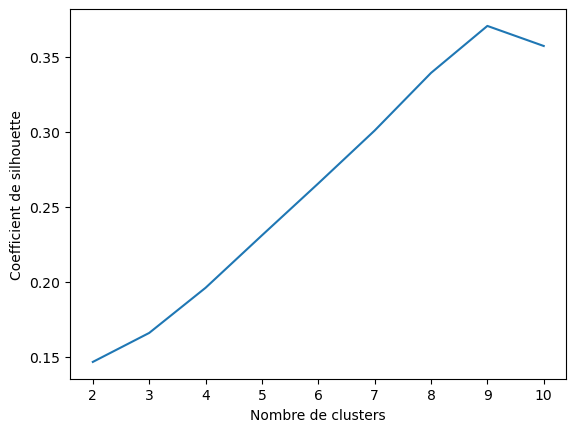

In [106]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np

# Définir la plage de nombre de clusters à tester
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Calculer le coefficient de silhouette pour chaque valeur de n_clusters
silhouette_scores = []
for n_clusters in range_n_clusters:
    model = AgglomerativeClustering(n_clusters=n_clusters)
    labels = model.fit_predict(df_sampled)
    silhouette_avg = silhouette_score(df_sampled, labels)
    silhouette_scores.append(silhouette_avg)

# Trouver le nombre optimal de clusters en maximisant le coefficient de silhouette
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]

# Afficher le graphique de coefficient de silhouette
plt.plot(range_n_clusters, silhouette_scores)
plt.xlabel('Nombre de clusters')
plt.ylabel('Coefficient de silhouette')
plt.show()

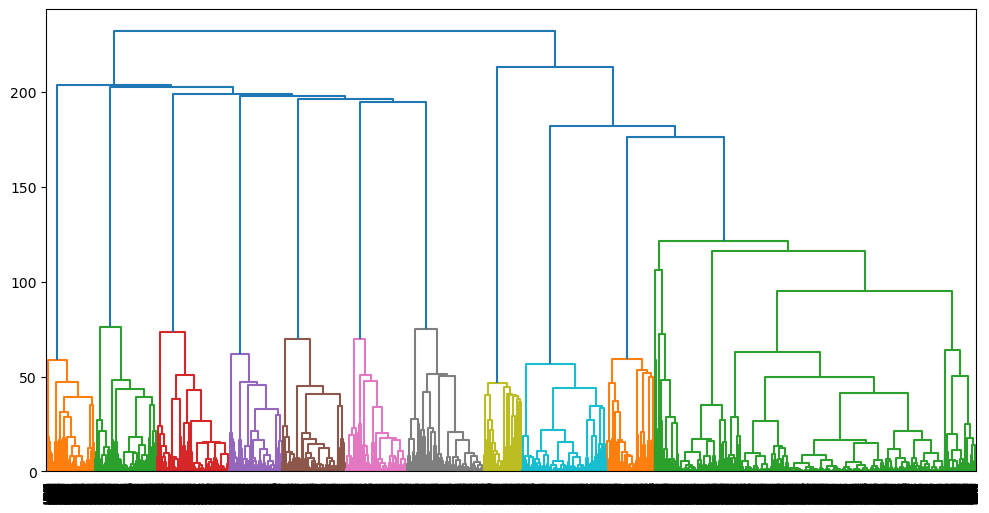

In [110]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(df_sample, method='ward')

# Tracer le dendrogramme
plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.show()

In [111]:
df_sample

,mean_delivery_time,mean_review_score,mean_order_price,mean_order_count,num_products,most_common_payment_type_boleto,most_common_payment_type_credit_card,most_common_payment_type_infrequent_sklearn,city_rio de janeiro,city_sao paulo,df_product_categories_beleza_saude,df_product_categories_cama_mesa_banho,df_product_categories_esporte_lazer,df_product_categories_informatica_acessorios,df_product_categories_moveis_decoracao,df_product_categories_relogios_presentes,df_product_categories_utilidades_domesticas,df_product_categories_infrequent_sklearn
41396,-0.850372,-2.188397,0.719836,5.103805,0.0,-0.504793,0.569614,-0.209136,-0.272776,2.306965,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,3.891916,-0.961607
49087,0.110587,-0.023960,-0.225865,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,3.466657,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
89478,0.217360,0.697519,0.037710,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
1841,0.217360,-0.023960,-0.148767,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
52498,-0.423279,-0.023960,-0.401445,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,-0.433470,3.264069,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4296,2.032503,-2.188397,-0.410706,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926
97407,0.644452,0.697519,0.063335,-0.234952,0.0,1.981009,-1.755574,-0.209136,-0.272776,-0.433470,-0.306366,-0.330199,-0.288462,3.654351,-0.282391,-0.236986,-0.256943,-0.961607
58518,-0.530052,0.697519,-0.345844,-0.234952,0.0,-0.504793,0.569614,-0.209136,-0.272776,-0.433470,-0.306366,3.028472,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,-0.961607
14070,-0.530052,-2.188397,0.903487,2.434427,0.0,1.981009,-1.755574,-0.209136,-0.272776,2.306965,-0.306366,-0.330199,-0.288462,-0.273646,-0.282391,-0.236986,-0.256943,1.039926


In [53]:
from sklearn.cluster import AgglomerativeClustering
import pandas as pd


# Créer le modèle de classification hiérarchique
model = AgglomerativeClustering(n_clusters=9,linkage='ward',metric='euclidean').fit(df_sampled)

In [55]:
silhouette_avg = silhouette_score(df_sampled, model.labels_)
print("Score silhouette moyen :", silhouette_avg)

Score silhouette moyen : 0.3831872946623012


In [62]:
# Calculer la taille de chaque cluster
cluster_sizes = df_sampled.groupby(model.labels_).size()

# Afficher les statistiques descriptives des tailles de cluster
print('Tailles des clusters \n:',cluster_sizes )
print(cluster_sizes.describe())

Tailles des clusters 
: 0    2082
1    7617
2    2619
3    1331
4    1695
5    1047
6     822
7    1649
8    1138
dtype: int64
count       9.000000
mean     2222.222222
std      2097.583537
min       822.000000
25%      1138.000000
50%      1649.000000
75%      2082.000000
max      7617.000000
dtype: float64


In [57]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_sampled)

# Projection 2D t-SNE
tsne = TSNE(n_components=2, perplexity=30.0, n_iter=1000, random_state=1)
tsne_result = tsne.fit_transform(df_sampled)

In [58]:
pca_array = pca_result.to_numpy()

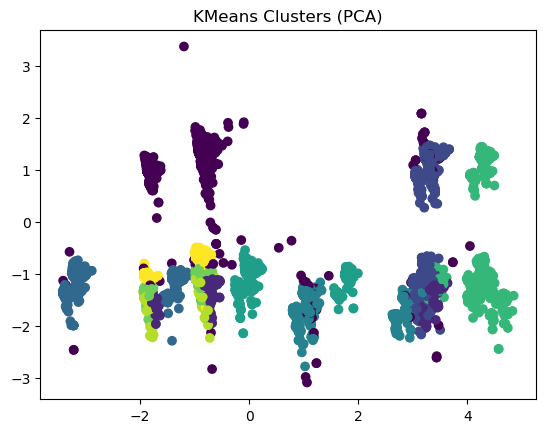

In [59]:
# Visualisation des clusters avec PCA
plt.scatter(pca_array[:, 0], pca_array[:, 1], c=labels)
plt.title("KMeans Clusters (PCA)")
plt.show()

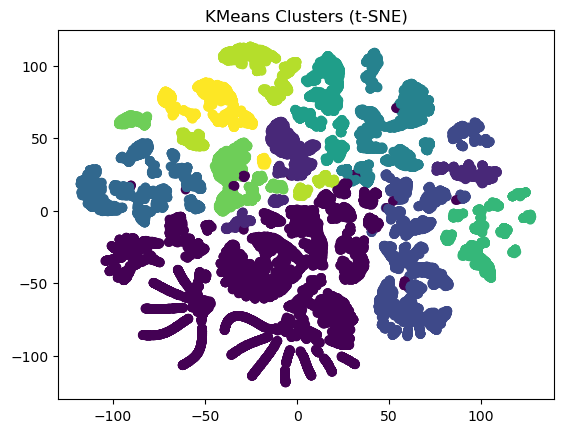

In [60]:
# Visualisation des clusters avec t-SNE
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels)
plt.title("KMeans Clusters (t-SNE)")
plt.show()

In [61]:
# Ajouter une colonne pour les labels de cluster
df_sampled['cluster'] = model.labels_

# Définir les définitions pour chaque cluster
cluster_definitions = {
    0: "Clients peu engagés : Paiement avec Boleto et achat de produits de beauté/santé et d'articles de literie/salle de bain",
    1: "Clients récents et fidèles : Paiement par carte de crédit et achat de produits d'informatique/accessoires et de meubles/décoration",
    2: "Clients anciens mais peu dépensiers : Paiement avec Boleto et achat de produits de sport/loisirs et d'articles pour la maison",
    3: "Clients très engagés : Paiement par carte de crédit et achat de produits de sport/loisirs et d'articles pour la maison",
    4: "Clients peu récents mais dépensiers : Paiement par carte de crédit et achat de produits de beauté/santé et d'articles pour la maison",
    5: "Clients récents mais peu engagés : Paiement avec Boleto et achat de produits de sport/loisirs et d'articles pour la maison",
    6: "Clients moyennement engagés : Paiement par carte de crédit et achat de produits de sport/loisirs et d'articles pour la maison",
    7: "Clients moyennement récents et dépensiers : Paiement par carte de crédit et achat de produits de sport/loisirs et d'articles pour la maison",
    8: "Clients moyennement récents et peu dépensiers : Paiement avec Boleto et achat de produits de sport/loisirs et d'articles pour la maison"
}

# Liste de variables à comparer
variables_to_compare = ['mean_delivery_time', 'mean_review_score', 'mean_order_price', 'most_common_payment_type_boleto', 'most_common_payment_type_credit_card', 'df_product_categories_beleza_saude', 'df_product_categories_cama_mesa_banho', 'df_product_categories_esporte_lazer', 'df_product_categories_informatica_acessorios', 'df_product_categories_moveis_decoracao', 'df_product_categories_relogios_presentes', 'df_product_categories_utilidades_domesticas']

# Parcourir chaque cluster et afficher sa définition et les moyennes pour chaque variable
for cluster_label, definition in cluster_definitions.items():
    print(f"Cluster {cluster_label}: {definition}")
    for variable in variables_to_compare:
        if 'most_common_payment_type' in variable:
            payment_type = variable.split('_')[-1]
            print(f"Paiement le plus commun : {payment_type} mean:", round(df_sampled[df_sampled['cluster'] == cluster_label][variable].mean(), 2))
        elif 'df_product_categories' in variable:
            category = variable.split('_')[-1]
            print(f"Achat de produits {category} mean:", round(df_sampled[df_sampled['cluster'] == cluster_label][variable].mean(), 2))
        else:
            print(f"{variable} mean:", round(df_sampled[df_sampled['cluster'] == cluster_label][variable].mean(), 2))
    print()


Cluster 0: Clients peu engagés : Paiement avec Boleto et achat de produits de beauté/santé et d'articles de literie/salle de bain
mean_delivery_time mean: -0.12
mean_review_score mean: 0.05
mean_order_price mean: -0.09
Paiement le plus commun : boleto mean: -0.5
Paiement le plus commun : card mean: 0.57
Achat de produits saude mean: -0.31
Achat de produits banho mean: -0.33
Achat de produits lazer mean: 1.82
Achat de produits acessorios mean: -0.27
Achat de produits decoracao mean: -0.28
Achat de produits presentes mean: -0.24
Achat de produits domesticas mean: 1.57

Cluster 1: Clients récents et fidèles : Paiement par carte de crédit et achat de produits d'informatique/accessoires et de meubles/décoration
mean_delivery_time mean: 0.0
mean_review_score mean: 0.02
mean_order_price mean: 0.08
Paiement le plus commun : boleto mean: -0.45
Paiement le plus commun : card mean: 0.52
Achat de produits saude mean: -0.3
Achat de produits banho mean: -0.27
Achat de produits lazer mean: -0.28
Acha

In [63]:
df_maintenance = df_sampled.copy()

In [64]:
df_maintenance['last_order_date'] = df_final['last_order_date']

In [66]:
df_maintenance.to_csv('Maintenance.csv',index=False)